# Planet to planet low-thrust transfer

In this tutorial we show the use of the {class}`pykep.trajopt.direct_pl2pl` to find a low-thrust trajectory connecting two moving planets. 

The decision vector for this class, compatible with {cite:p}`pagmo` UDPs (User Defined Problems), is:

$$
\mathbf x = [t_0, m_f, V_{sx}^\infty, V^\infty_{sy}, V^\infty_{sz}, V^\infty_{fx}, V^\infty_{fy}, V^\infty_{fz}, u_{x0}, u_{y0}, u_{z0}, u_{x1}, u_{y1}, u_{z1}, ..., T_{tof}]
$$

containing the starting epoch $t_0$ as a MJD2000, the final mass $m_f$ as well as the starting and final $V^{\infty}$, throttles and the time-of-flight $T_{tof}$.

:::{note}
This notebook makes use of the commercial solver SNOPT 7 and to run needs a valid `snopt_7_c` library installed in the system. In case SNOPT7 is not available, you can still run the notebook using, for example `uda = pg.algorithm.nlopt("slsqp")` with minor modifications.

Basic imports:

In [1]:
import pykep as _pk
import numpy as _np
import time
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
import time

from matplotlib import pyplot as plt

In [240]:
import numpy as _np
import pykep as _pk

earth = _pk.planet(_pk.udpla.jpl_lp(body="EARTH"))
mars = _pk.planet(_pk.udpla.jpl_lp(body="MARS"))


class direct_pl2pl:
    """Represents the optimal low-thrust transfer between two :class:`~pykep.planet` using a direct method.

    This problem works internally using the :class:`~pykep.leg.sims_flanagan` and manipulates its initial and final states, as well as its transfer time T, final mass mf
    and the controls as to link the two planets with a low-thrust trajectory.

    The particular transcription used is suitable only for few revolutions, after which convergence will start to be problematic.

    The decision vector is::

        z = [t0, mf, Vsx, Vsy, Vsz, Vfx, Vfy, Vfz, throttles, tof]

    where throttles is a vector of throttles structured as [u0x, u0y,u0z, ...]. By throttles we intend non dimensiona thrust levels in [0,1].

    """

    def __init__(
        self,
        pls=earth,
        plf=mars,
        ms=1000,
        mu=_pk.MU_SUN,
        max_thrust=0.12,
        isp=3000,
        t0_bounds=[4000.0, 5000],
        tof_bounds=[80, 400],
        mf_bounds=[200.0, 1000.0],
        vinfs=1e-3,
        vinff=1e-3,
        nseg=10,
        cut=0.6,
        mass_scaling=1000,
        r_scaling=_pk.AU,
        v_scaling=_pk.EARTH_VELOCITY,
        with_gradient=True,
    ):
        """
        Initializes the direct_pl2pl instance with given parameters.

        Args:
            *pls* (:class:`~pykep.planet`): Initial planet.

            *plf* (:class:`~pykep.planet`): Final planet.

            *ms* (:class:`float`): Initial spacecraft mass in kg. Defaults to 1000 kg.

            *mu* (:class:`float`): Gravitational parameter, default is for the Sun (:class:`~pykep.MU_SUN`).

            *max_thrust* (:class:`float`): Maximum thrust in Newtons. Defaults to 0.12 N.

            *isp* (:class:`float`): Specific impulse in seconds. Defaults to 3000 s.

            *t0_bounds* (:class:`list`): Bounds for departure epoch in MJD2000. Defaults to [4000, 5000] days.

            *tof_bounds* (:class:`list`): Bounds for time of flight in days. Defaults to [0, 400] days.

            *mf_bounds* (:class:`list`): Bounds for final mass in kg. Defaults to [200.0, 1000.0] kg.

            *vinfs* (:class:`float`): Allowed magnitude for the departure's relative velocity in km/s. Defaults to 1e-3.

            *vinff* (:class:`float`): Allowed magnitude for the arrival's relative velocity in km/s. Defaults to 1e-3.

            *nseg* (:class:`int`): Number of segments for the trajectory. Defaults to 10.

            *cut* (:class:`float`): Cut parameter for the :class:`~pykep.leg.sims_flanagan`. Defaults to 0.6.

            *mass_scaling* (:class:`float`): Scaling factor for mass (used to scale constraints). Defaults to 1000.

            *r_scaling* (:class:`float`): Scaling factor for distance, (used to scale constraints). Defaults AU (:class:`~pykep.AU`).

            *v_scaling* (:class:`float`): Scaling factor for velocity (used to scale constraints). Defaults the Earth's velocity (:class:`~pykep.EARTH_VELOCITY`).

            *with_gradient* (:class:`bool`): Indicates if gradient information should be used. Defaults True.

        """
        # We add as data member one single Sims-Flanagan leg and set it using problem data
        self.leg = _pk.leg.sims_flanagan()
        self.leg.ms = ms
        self.leg.max_thrust = max_thrust
        self.leg.isp = isp
        self.leg.mu = mu
        self.leg.cut = cut

        # We define some additional datamembers useful later-on
        self.pls = pls
        self.plf = plf
        self.t0_bounds = t0_bounds
        self.tof_bounds = tof_bounds
        self.mf_bounds = mf_bounds
        self.vinfs = vinfs * 1000
        self.vinff = vinff * 1000
        self.nseg = nseg
        self.mass_scaling = mass_scaling
        self.r_scaling = r_scaling
        self.v_scaling = v_scaling
        self.with_gradient = with_gradient

    # z = [t0, mf, Vsx, Vsy, Vsz, Vfx, Vfy, Vfz, throttles, tof]
    def get_bounds(self):
        lb = (
            [self.t0_bounds[0], self.mf_bounds[0]]
            + [-self.vinfs] * 3  # in m/s.
            + [-self.vinff] * 3  # in m/s.
            + [-1, -1, -1] * self.nseg
            + [self.tof_bounds[0]]
        )
        ub = (
            [self.t0_bounds[1], self.mf_bounds[1]]
            + [self.vinfs] * 3  # in m/s.
            + [self.vinff] * 3  # in m/s.
            + [1, 1, 1] * self.nseg
            + [self.tof_bounds[1]]
        )
        return (lb, ub)

    def _set_leg_from_x(self, x):
        # We set the leg using data in the decision vector
        rs, vs = self.pls.eph(x[0]*_pk.SEC2DAY)
        rf, vf = self.plf.eph(x[0]*_pk.SEC2DAY + x[-1])
        self.leg.rvs = [rs, [a + b for a, b in zip(vs, x[2:5])]]  # we added vinfs
        self.leg.rvf = [rf, [a + b for a, b in zip(vf, x[5:8])]]  # we added vinfs
        self.leg.tof = x[-1] * _pk.DAY2SEC
        self.leg.mf = x[1]
        self.leg.throttles = x[8:-1]

    # z = [t0, mf, Vsx, Vsy, Vsz, Vfx, Vfy, Vfz, throttles, tof]
    def fitness(self, x):
        # 1 - We set the optimality principle
        mf = x[1]

        # 2 - We compute the constraints violations (mismatch+throttle)
        self._set_leg_from_x(x)  # set the leg
        ceq = self.leg.compute_mismatch_constraints()
        cineq = self.leg.compute_throttle_constraints()
        # We add the departure vinfs constraint (quadratic)
        cineq = cineq + [
            (x[2] ** 2 + x[3] ** 2 + x[4] ** 2 - self.vinfs**2) / (self.v_scaling**2)
        ]
        # We add the departure vinff constraint (quadratic)
        cineq = cineq + [
            (x[5] ** 2 + x[6] ** 2 + x[7] ** 2 - self.vinff**2) / (self.v_scaling**2)
        ]
        retval = _np.array([-mf] + ceq + cineq)  # here we can sum lists

        # 3 - We scale the values in nd units (numerical solvers are sensitive to well-scaled values)
        retval[0] /= self.mass_scaling
        retval[1:4] #/= self.r_scaling
        retval[4:7] /= self.v_scaling
        retval[7] /= self.mass_scaling

        return retval

    # def has_gradient(self):
    #    return self.with_gradient

    def gradient(self, x):
        self._set_leg_from_x(x)
        mcg_xs, mcg_xf, mcg_th_tof = self.leg.compute_mc_grad()
        tcg_th = self.leg.compute_tc_grad()
        rs, vs = self.pls.eph(x[0]*_pk.SEC2DAY)
        rf, vf = self.plf.eph(x[0]*_pk.SEC2DAY + x[-1])

        # 1 - The gradient of the objective function (obj = -mf)
        retval = [-1.0 / self.mass_scaling]
        # 2 - The gradient of the mismatch contraints (mcg). We divide them in pos, vel mass as they have different scaling units

        ## pos
        for i in range(3):
            # First w.r.t. t0 (it is in days in the decision vector, so we will need to convert)
            tmp = (
                +_np.dot(mcg_xs[i, :3], vs)
                - _np.dot(mcg_xs[i, 3:6], rs) * self.leg.mu / (_np.linalg.norm(rs) ** 3)
                - _np.dot(mcg_xf[i, :3], vf)
                + _np.dot(mcg_xf[i, 3:6], rf) * self.leg.mu / (_np.linalg.norm(rf) ** 3)
            )
            retval.append(tmp)
            ## First w.r.t. mf
            # retval.append(mcg_xf[i, -1] / self.r_scaling)
            ## Then the [throttles, tof]
            # retval.extend(mcg_th_tof[i, :] / self.r_scaling)
            # retval[-1] *= _pk.DAY2SEC
        ## vel
        # for i in range(3, 6):
        #    # First w.r.t. mf
        #    retval.append(mcg_xf[i, -1] / self.v_scaling)
        #    # Then the [throttles, tof]
        #    retval.extend(mcg_th_tof[i, :] / self.v_scaling)
        #    retval[-1] *= _pk.DAY2SEC
        ## mass
        # for i in range(6, 7):
        #    # First w.r.t. mf
        #    retval.append(mcg_xf[i, -1] / self.mass_scaling)
        #    # Then the [throttles, tof]
        #    retval.extend(mcg_th_tof[i, :] / self.mass_scaling)
        #    retval[-1] *= _pk.DAY2SEC
        ## 3 -  The gradient of the throttle constraints
        # for i in range(self.leg.nseg):
        #    retval.extend(tcg_th[i, 3 * i : 3 * i + 3])

        return retval

    def gradient_sparsity(self):
        dim = 9 + 3 * self.nseg
        # The objective function only depends on the final mass, which is in the chromosome.
        retval = [[0, 1]]
        # The mismatch constraints on x,y,z,vx,vy,vz depend on all variables.
        for i in range(1, 7):
            for j in range(dim):
                retval.append([i, j])
        # The mismatch constraints on m depend on all variables except the vinfs, vinff, t0
        retval.append([7, 1])
        for j in range(8, dim):
            retval.append([7, j])
        # The throttle constraints only depend on the specific throttles (3).
        for i in range(self.nseg):
            retval.append([8 + i, 3 * i + 8])
            retval.append([8 + i, 3 * i + 9])
            retval.append([8 + i, 3 * i + 10])
        # The constraints on vinfs, vinff only depend on the vinfs, vinff
        for j in range(2, 5):
            retval.append([8 + self.nseg, j])
        for j in range(5, 8):
            retval.append([9 + self.nseg, j])
        # We return the sparsity pattern
        return retval

    def get_nec(self):
        return 7

    def get_nic(self):
        return self.nseg + 2

    def pretty(self, x):
        """
        Prints a detailed representation of the Point to point problem.

        Args:
            *x* (:class:`list`): The decision vector containing final mass, thrust direction, and time of flight.
        """
        self._set_leg_from_x(x)
        print(self.leg)

    def plot(
        self,
        x,
        ax=None,
        units=_pk.AU,
        show_midpoints=False,
        show_gridpoints=False,
        show_throttles=False,
        length=0.1,
        arrow_length_ratio=0.05,
        **kwargs
    ):
        """
        Plots the trajectory leg  3D axes.
        Args:
            *x* (:class:`list`): The decision vector containing final mass, thrust direction, and time of flight.
            *ax* (:class:`mpl_toolkits.mplot3d.axes3d.Axes3D`, optional): The 3D axis to plot on. Defaults to None.
            *units* (:class:`float`, optional): The unit scale for the plot. Defaults to _pk.AU.
            *show_midpoints* (:class:`bool`, optional): Whether to show midpoints on the trajectory. Defaults to False.
            *show_gridpoints* (:class:`bool`, optional): Whether to show grid points on the trajectory. Defaults to False.
            *show_throttles* (:class:`bool`, optional): Whether to show throttle vectors. Defaults to False.
            *length* (:class:`float`, optional): Length of the throttle vectors. Defaults to 0.1.
            *arrow_length_ratio* (:class:`float`, optional): Arrow length ratio for the throttle vectors. Defaults to 0.05.
            *\*\*kwargs*: Additional keyword arguments for the plot.
        Returns:
            :class:`mpl_toolkits.mplot3d.axes3d.Axes3D`: The 3D axis with the plotted trajectory.
        """
        self._set_leg_from_x(x)
        sf = self.leg
        # Making the axis
        if ax is None:
            ax = _pk.plot.make_3Daxis(figsize=(7, 7))
        rs, _ = sf.rvs
        rf, _ = sf.rvf
        ax.scatter(rs[0] / _pk.AU, rs[1] / units, rs[2] / units, c="k", s=20)
        ax.scatter(rf[0] / _pk.AU, rf[1] / units, rf[2] / units, c="k", s=20)

        # Plotting planets
        ax = _pk.plot.add_planet(ax, self.pls, when=x[0])
        ax = _pk.plot.add_planet_orbit(ax, self.pls, c="gray", alpha=0.5)
        ax = _pk.plot.add_planet(ax, self.plf, when=x[0] + x[-1])
        ax = _pk.plot.add_planet_orbit(ax, self.plf, c="gray", alpha=0.5)

        # Plotting the trajctory leg
        ax = _pk.plot.add_sf_leg(
            ax,
            sf,
            units=units,
            show_throttles=show_throttles,
            length=length,
            show_gridpoints=show_gridpoints,
            show_midpoints=show_midpoints,
            arrow_length_ratio=arrow_length_ratio,
            **kwargs
        )

        return ax

In [241]:
# Problem data
mu = _pk.MU_SUN
max_thrust = 0.3
isp = 3000

# Initial state
ms = 1500.0
pls = earth

# Final state
plf = mars

# Throttles and tof
nseg = 2

udp_nog = direct_pl2pl(
        pls=pls,
        plf=plf,
        ms=ms,
        mu=_pk.MU_SUN,
        max_thrust=max_thrust,
        isp=3000,
        t0_bounds=[6000.0, 7000.0],
        tof_bounds=[180.0, 900.0],
        mf_bounds=[1300., ms],
        vinfs=3.,
        vinff=0.,
        nseg=nseg,
        cut=0.6,
        mass_scaling=ms,
        r_scaling=_pk.AU,
        v_scaling=_pk.EARTH_VELOCITY,
        with_gradient=False,
)

In [242]:
    # z = [t0, mf, Vsx, Vsy, Vsz, Vfx, Vfy, Vfz, throttles, tof]

In [243]:
prob_nog = pg.problem(udp_nog)
prob_nog.c_tol = 1e-6
pop_nog = pg.population(prob_nog, 1)


In [248]:
pg.estimate_gradient_h(udp_nog.fitness, pop_nog.champion_x)[15:18]

array([   31104.79142521, 14571109.23377023, 10236784.9152134 ])

In [247]:
udp_nog.gradient(pop_nog.champion_x)[1:4]

[31104.263713850818, 22096.937586088996, -1117.099192672489]

In [35]:
snopt72 = "/Users/dario.izzo/opt/libsnopt7_c.dylib"
uda = ppnf.snopt7(library=snopt72, minor_version=2, screen_output=False)
uda.set_integer_option("Major iterations limit", 2000)
uda.set_integer_option("Iterations limit", 20000)
uda.set_numeric_option("Major optimality tolerance", 1e-4)
uda.set_numeric_option("Major feasibility tolerance", 1e-11)

# uda = pg.nlopt("slsqp")
algo = pg.algorithm(uda)

In [36]:
for i in range(10):
    prob_nog = pg.problem(udp_nog)
    prob_nog.c_tol = 1e-6
    pop_nog = pg.population(prob_nog, 1)
    pop_nog = algo.evolve(pop_nog)
    if(prob_nog.feasibility_f(pop_nog.champion_f)):
        print(".")
        break
    print("x", end ="")
print("mass is: ", pop_nog.get_x()[0][1])

.
mass is:  1346.289643529705


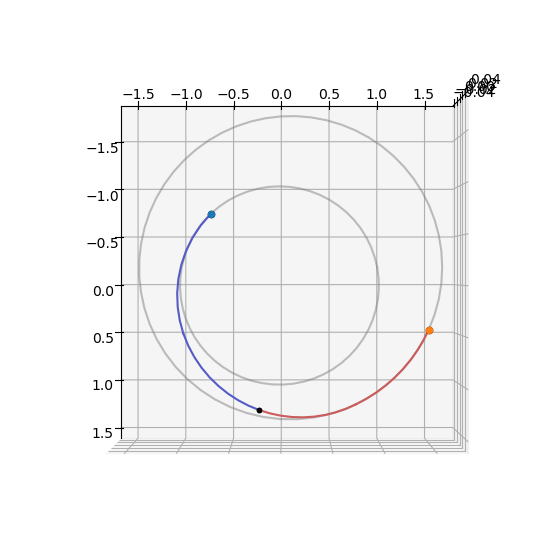

In [37]:
ax = udp_nog.plot(pop_nog.get_x()[0], show_gridpoints=True)
ax.view_init(90, 0)

In [32]:
pop_nog = pg.population(prob_nog, 1)
a = pg.estimate_sparsity(udp_nog.fitness, pop_nog.champion_x)
b = udp_nog.gradient_sparsity()

In [33]:
_np.all(a==b)

True